## **Link do Projeto no Colab**

---

https://colab.research.google.com/drive/1tAkXwPTVdzC4Hwwn72MQLsuwgIjX3BAu#scrollTo=2d1IIqYCbY3l

## **Introdução**
---

Neste estudo, vamos explorar os dados de investigação das perguntas feitas ao nosso paciente virtual, o Simplício, armazenados no drive da MedRoom. A base de dados contém os áudios do diálogos entre pessoas reais e o paciente virtual. Nosso objetivo é conseguir transcrever esses áudios em textos

Utilizaremos técnicas e ferramentas para extrair informações valiosas da base de dados obtendo os textos referentes à cada áudio.

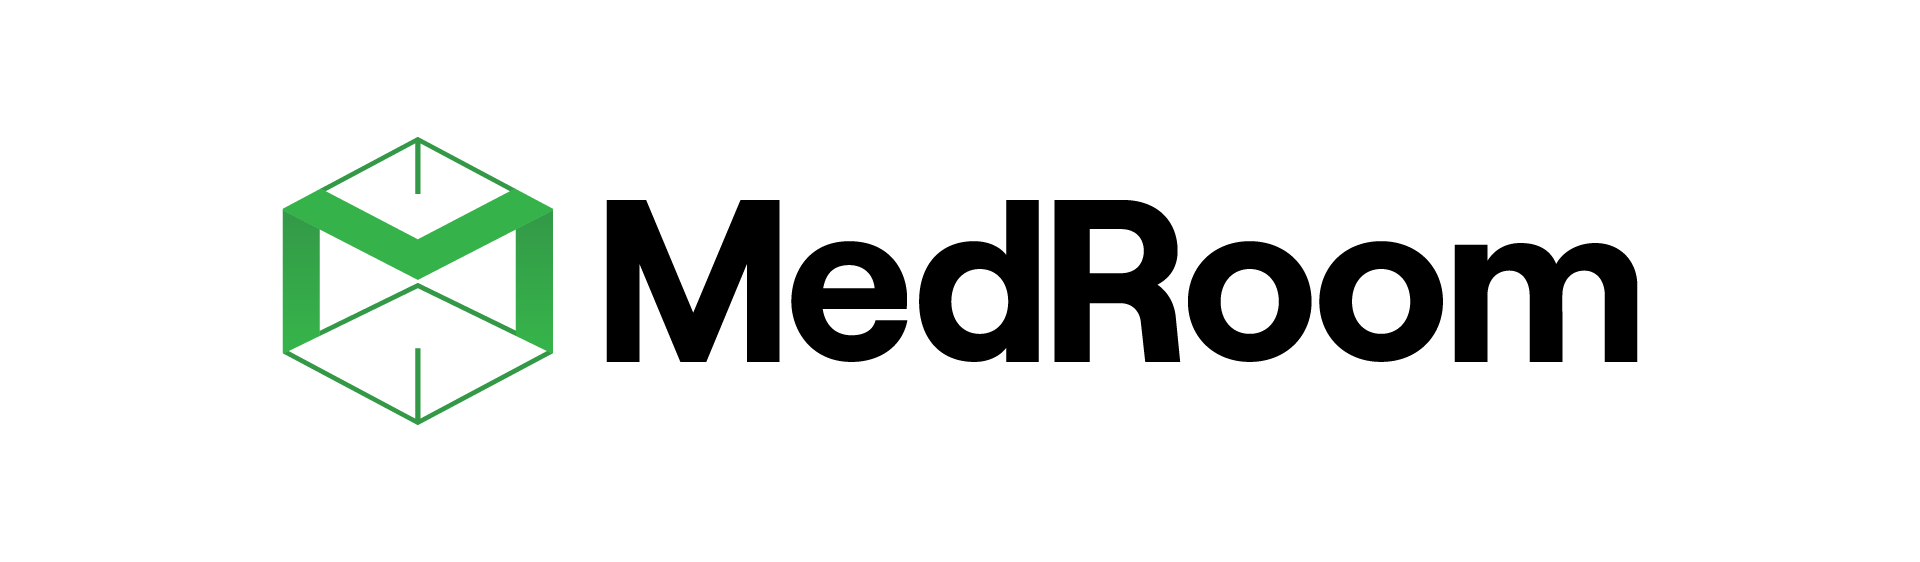

## **Objetivo**
---

Nosso objetivo é obter as transcrições em texto dos áudios

## **Sobre os dados**
---

São áudio contidos na base de dados do paciente virtual Simplício, além de um arquivo contendo a transcrição original dos áudios. Nos dados temos o total de 446 arquivos

<img src="https://media.giphy.com/media/dQpUkK59l5Imxsh8jN/giphy.gif" alt="win" width="600"/>

#**Coleta de dados**

### **Bibliotecas**
---

Primeiro, vamos importar as bibliotecas necessárias:

In [ ]:
!pip install rarfile
!pip install pydub
!pip install noisereduce
!pip install SpeechRecognition
!pip install librosa
!pip install sounddevice
!sudo apt-get install portaudio19-dev
!pip install jiwer
!pip install nltk
import io
import rarfile
import os
import numpy as np
import noisereduce as nr
import speech_recognition as sr
import jiwer
from jiwer import wer, cer
import re
from pydub import AudioSegment
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

### **Dataframe**
---

Em seguida, vamos carregar o DataFrame com os dados:

In [3]:
# Caminho para o arquivo .rar
rar_file_path = '/content/Simplício.rar'

# Diretório para extrair os arquivos do .rar
extracted_dir = '/content/extracted_files'
os.makedirs(extracted_dir, exist_ok=True)

# Lista para armazenar os áudios extraídos
audios = []

# Abrir o arquivo .rar em modo leitura
with rarfile.RarFile(rar_file_path, 'r') as rf:
    # Lista de nomes de arquivos dentro do .rar
    file_names_in_rar = rf.namelist()

    # Iterar sobre os arquivos dentro do .rar
    for file_name in file_names_in_rar:
        # Verificar se o arquivo é um arquivo de áudio (por exemplo, .mp3 ou .wav)
        if file_name.lower().endswith('.mp3') or file_name.lower().endswith('.wav'):
            # Ler o conteúdo do arquivo em memória
            with rf.open(file_name) as file_in_rar:
                audio_data = file_in_rar.read()
                audio = AudioSegment.from_file(io.BytesIO(audio_data))

                # Adicionar o áudio à lista de áudios extraídos
                audios.append(audio)

In [4]:
len(audios)

446

# **Limpeza e tratamento**
---


Aqui vamos realizar etapas importantes para trabalahar com áudios como remover os ruídos e a normalização

***Remoção de Ruidos***

In [5]:
def remove_noise(audio, profile_duration=3.0):
    audio_data = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate

    # Tamanho da janela para criar o perfil de ruído (em amostras)
    profile_size = int(sample_rate * profile_duration)

    # Crie um perfil de ruído usando uma parte silenciosa do áudio
    noise_profile = audio_data[:profile_size]

    # Aplique o perfil de ruído para remover o ruído do restante do áudio
    denoised_data = nr.reduce_noise(y=audio_data, sr=sample_rate)

    # Converta os dados denoised_data de volta para um objeto AudioSegment
    denoised_audio = AudioSegment(
        data=denoised_data.tobytes(),
        sample_width=audio.sample_width,
        frame_rate=sample_rate,
        channels=audio.channels
    )
    return denoised_audio

# Lista para armazenar os áudios processados
processed_audios = []

# Processar cada áudio da lista
for audio in audios:
    denoised_audio = remove_noise(audio)
    processed_audios.append(denoised_audio)

In [6]:
len(processed_audios)

446

**Normalizar os Áudios**

In [7]:
def normalize_audio(audio, target_dBFS=-20):
    change_in_dBFS = target_dBFS - audio.dBFS
    normalized_audio = audio.apply_gain(change_in_dBFS)
    return normalized_audio

# Lista para armazenar os áudios normalizados
normalized_audios = []

# Normalizar cada áudio da lista
for denoised_audio in processed_audios:
    normalized_audio = normalize_audio(denoised_audio)
    normalized_audios.append(normalized_audio)

In [8]:
normalized_audios[1]

Escutando o áudio vê-se que a extração a manipulação dos áudios parece ter ocorrido como esperado

**Verificando o áudio normalizado**

In [9]:
output = '/content/'

In [10]:
audio_index = 0

In [11]:
output_filename = f'audio_{audio_index + 1}.wav'
audio = normalized_audios[audio_index]
audio.export(output + output_filename, format='wav')

print(f'Áudio {output_filename} salvo com sucesso.')

Áudio audio_1.wav salvo com sucesso.


#**Transcrição dos Áudios**
----

Agora vamos rodar o modelo obtido via API que irá transcrever os áudios

In [12]:
# Função para transcrever um áudio
def transcribe_audio(audio):
    recognizer = sr.Recognizer()

    # Converter o objeto AudioSegment em áudio no formato WAV (SpeechRecognition só suporta áudio WAV)
    wav_data = audio.raw_data

    # Salvar o áudio como arquivo WAV temporário
    wav_temp_file = "temp_audio.wav"
    audio.export(wav_temp_file, format="wav")

    # Realizar a transcrição usando o Google Web Speech API
    try:
        with sr.AudioFile(wav_temp_file) as source:
            audio_wav = recognizer.record(source)
            transcription = recognizer.recognize_google(audio_wav, language="pt-BR")

        # Realizar o pós-processamento para manter letras maiúsculas no início das frases
        processed_text = []
        capitalize_next = True
        for word in transcription.split():
            if capitalize_next:
                processed_text.append(word.capitalize())
                capitalize_next = False
            else:
                processed_text.append(word)

            if re.match(r'[.!?]', word):
                capitalize_next = True

        final_transcription = ' '.join(processed_text)
        return final_transcription
    except sr.UnknownValueError:
        return "Transcrição não identificada"
    except sr.RequestError as e:
        return "Erro na requisição ao serviço de transcrição: {0}".format(e)

# Lista para armazenar as transcrições
all_transcribed_audios = []

# Iterar sobre os áudios normalizados
for normalized_audio in normalized_audios:
    transcription = transcribe_audio(normalized_audio)
    all_transcribed_audios.append((normalized_audio, transcription))

In [13]:
all_transcribed_audios[0]

(<pydub.audio_segment.AudioSegment at 0x7da5c1ecfc70>,
 'Pode ser perigoso é importante lidar com isso da mesma maneira que você lidaria com outras coisas que podem ser potencialmente perigosas')

In [14]:
# Suponhamos que 'all_transcribed_audios' seja a estrutura com as transcrições e áudios normalizados
total_audios = len(all_transcribed_audios)
transcribed_count = 0
unidentified_count = 0

for _, transcription in all_transcribed_audios:
    if transcription != "Transcrição não identificada":
        transcribed_count += 1
    else:
        unidentified_count += 1

# Calcular a porcentagem de sucesso
success_percentage = (transcribed_count / total_audios) * 100

print(f"Total de áudios: {total_audios}")
print(f"Áudios transcritos: {transcribed_count}")
print(f"Áudios com transcrição não identificada: {unidentified_count}")
print(f"Porcentagem de sucesso: {success_percentage:.2f}%")

Total de áudios: 446
Áudios transcritos: 419
Áudios com transcrição não identificada: 27
Porcentagem de sucesso: 93.95%


O modelo não foi capaz de identificar todos os áudios, ficaram 28 áudios ou 6,28% dos áudios ficaram sem transcrição

#**Avaliar o desempenho**
----

In [15]:
# Caminho para o arquivo .rar
rar_file_path = '/content/Simplício.rar'

# Abrir o arquivo .rar em modo leitura
with rarfile.RarFile(rar_file_path, 'r') as rf:
    # Extrair o conteúdo do arquivo de transcrições
    transcription_file = rf.extract('transcricao.txt')

    # Ler as transcrições reais do arquivo
    with open(transcription_file, 'r') as f:
        actual_transcriptions = f.readlines()

# Função para extrair números das frases
def extract_number(text):
    stripped_text = text.strip()
    if stripped_text and stripped_text.startswith('CNVSample'):
        return int(stripped_text.replace('CNVSample', '').split('\t', 1)[0])
    return float('inf')  # Usamos float('inf') para garantir que as linhas em branco sejam colocadas no final

# Ordenar as frases reais de acordo com os números
sorted_indices = sorted(range(len(actual_transcriptions)), key=lambda i: extract_number(actual_transcriptions[i]))
sorted_actual_transcriptions = [actual_transcriptions[i] for i in sorted_indices if extract_number(actual_transcriptions[i]) != float('inf')]

# Função para processar a transcrição obtida
def process_obtained_transcription(transcription):
    # Remover espaços extras entre as letras da mesma palavra
    processed_transcription = ' '.join(transcription.split())

    # Manter a diferenciação entre as palavras, acentos e letras maiúsculas
    return processed_transcription

# Processar as transcrições reais
processed_actual_transcriptions = [re.sub(r'^CNVSample\d+\t', '', transcription.strip()) for transcription in sorted_actual_transcriptions]

# Calcular WER e CER para cada transcrição
wer_total = 0
cer_total = 0
total_transcriptions = len(processed_actual_transcriptions)

for (audio_segment, transcriptions), actual_transcription in zip(all_transcribed_audios, processed_actual_transcriptions):
    # Obter a transcrição obtida como uma única string
    obtained_transcription = ''.join(transcriptions)

    # Processar a transcrição obtida
    processed_obtained_transcription = process_obtained_transcription(obtained_transcription)

    # Calcular WER e CER
    wer_1 = jiwer.wer(actual_transcription, processed_obtained_transcription)
    cer_1 = jiwer.cer(actual_transcription, processed_obtained_transcription)

    wer_total += wer_1
    cer_total += cer_1

average_wer = (wer_total / total_transcriptions) * 100
average_cer = (cer_total / total_transcriptions) * 100

print(f"Word Error Rate (WER): {average_wer:.2f} %")
print(f"Character Error Rate (CER): {average_cer:.2f} %")

Word Error Rate (WER): 44.73 %
Character Error Rate (CER): 25.16 %


Tivemos taxas altas de erro, o modelo erro quase metade das palavras (44,83%) e isso é bem alto

In [16]:
for real_transcription, (audio_segment, transcriptions) in zip(processed_actual_transcriptions, all_transcribed_audios):
    obtained_transcription = ''.join(transcriptions)
    print(f"Real: {real_transcription} | Obtido: {obtained_transcription}")

Real: Pode ser perigoso — e é importante lidar com isso da mesma maneira que você lidaria com outras coisas que podem ser potencialmente perigosas. | Obtido: Pode ser perigoso é importante lidar com isso da mesma maneira que você lidaria com outras coisas que podem ser potencialmente perigosas
Real: Sim, claro. Se tiver prejudicial para a minha saúde eu quero muito conhecer esse pessoal. | Obtido: Sim claro se tiver prejudicial para minha saúde eu quero muito conhecer esse pessoal
Real: Costumo beber socialmente, não é todo dia não. | Obtido: Consumo beber socialmente não é todo dia
Real: Eu ficaria nervoso jogando com tanta gente. | Obtido: Música de nervoso jogando com tanta gente
Real: Esse sempre foi meu sonho. | Obtido: Esse sempre foi o meu
Real: Eu quero ir lá também. | Obtido: Eu quero ir lá também
Real: Esse é o nosso segredo. | Obtido: Esse é o nosso segredo
Real: A polícia de S P esta atrás do bandido. | Obtido: A polícia de SP está transpa
Real: Sinto muita dor de cabeça du

#**Pós Processamento**
-----

Vamos realizar um pós-processamento com o objetivo de diminuir as taxas de erro

In [17]:
def postprocess_text(text):
    # Remover caracteres especiais, mantendo apenas letras e espaços
    text = re.sub(r'[^\w\s]', '', text)

    # Obter o conjunto de stopwords para o idioma português
    stop_words = set(stopwords.words("portuguese"))

    # Inicializar o lematizador para o idioma português
    lemmatizer = WordNetLemmatizer()

    # Dividir o texto em palavras usando a função word_tokenize do NLTK
    words = word_tokenize(text)

    # Aplicar lematização e remoção de stopwords nas palavras
    new_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]

    # Juntar as palavras lematizadas em uma única string, separadas por espaço
    return " ".join(new_words)

In [18]:
# Inicializar listas para armazenar as frases pós-processadas
postprocessed_references = []
postprocessed_predictions = []

for real_transcription, (audio_segment, transcriptions) in zip(processed_actual_transcriptions, all_transcribed_audios):
    obtained_transcription = ''.join(transcriptions)

    # Aplicar o pós-processamento em cada frase das referências e previsões
    postprocessed_reference = postprocess_text(real_transcription)
    postprocessed_prediction = postprocess_text(obtained_transcription)

    # Adicionar as frases pós-processadas às listas
    postprocessed_references.append(postprocessed_reference)
    postprocessed_predictions.append(postprocessed_prediction)

In [19]:
postprocessed_predictions

['pode perigoso importante lidar mesma maneira lidaria outras coisas podem potencialmente perigosas',
 'sim claro prejudicial saúde quero conhecer pessoal',
 'consumo beber socialmente todo dia',
 'música nervoso jogando tanta gente',
 'sempre',
 'quero ir lá',
 'segredo',
 'polícia sp transpa',
 'sinto muita dor cabeça durante semana',
 'resposta cris',
 'dizendo nada',
 'tempo tá',
 'quero pintar branco',
 'esclarecemos serviço',
 'começa sistemicamente',
 'pode decidir sozinha',
 'finalmente faz alta',
 'devemos ter maior atenção',
 'iremos conversar fáceis podemos conhecer amor',
 'quero saber detalhes',
 'porque vós pareça congelador abaixo totalmente melhor vida geladeira',
 'gosta ler h',
 'tentei melhor enganálo vou sentir através',
 'onde acho código qr',
 'muitíssimo obrigado atendimento feliz deus abençoe',
 'toalha roupas secas bebida aqui disposição ajudála cq',
 'tudo precisa fazer aceitar cadeia bem devagar levando três cinco segundos',
 'derreteu filho nessa quintafeira

In [20]:
postprocessed_references

['pode perigoso importante lidar mesma maneira lidaria outras coisas podem potencialmente perigosas',
 'sim claro prejudicial saúde quero conhecer pessoal',
 'costumo beber socialmente todo dia',
 'ficaria nervoso jogando tanta gente',
 'sempre sonho',
 'quero ir lá',
 'segredo',
 'polícia s p atrás bandido',
 'sinto muita dor cabeça durante semana',
 'resposta deram',
 'dizendo nada',
 'tempo tá quente',
 'quero pintar branco',
 'esclarecemos serviços',
 'começa sistematicamente',
 'pode decidir sozinha',
 'finalmente faz algo',
 'devemos ter maior atenção',
 'iremos começar uma fáceis podermos conhecer outro',
 'quero saber detalhes',
 'porque ilógico pareça correr ladeira abaixo provavelmente melhor mim correr ladeira acima',
 'gosta ler h q',
 'tentei melhor enganálo viu através mim',
 'onde acho código q r',
 'muitíssimo obrigado atendimento feliz deus abençõe',
 'toalha roupas secas bebida quente disposição ajudálo aquecer',
 'tudo precisa fazer sentar cadeira bem devagar levando

Analisando as Frases reais e as frases transcritas pelo modelo podemos apontar algumas diferenças que estão diminuindo o desempenho
* Ele teve algumas transcrições não identificadas
* Ele teve problema para transcrever horários
* Não conseguiu pegar girias e variações linguísticas com "mainha" e "painho"
* Teve muitos casos que ele não pegou a frase completa

Apesar disso as taxas de erro realmente diminuiram com o pós-processamento

**Score WER**

In [21]:
wer_score_final = wer(postprocessed_references, postprocessed_predictions)
print(f"Taxa de Erro de Palavras (WER): {wer_score_final:.2%}")

Taxa de Erro de Palavras (WER): 38.35%


**Score CER**

In [22]:
cer_score_final = cer(postprocessed_references, postprocessed_predictions)
print(f"Taxa de Erro de Caracteres (CER): {cer_score_final:.2%}")

Taxa de Erro de Caracteres (CER): 24.82%


#**Conclusão**
------

Esee projeto teve o objetivo de testar um modelo transcritor de áudios testando também todas as etapas de pré e pós processamento
Nesse notebook testei o modelo da API Googl Web API que atingiu taxas de erro de:
* Erro de palavras (WER): 38,49%
* Erro de caracteres (CER): 24,95%

Essas taxas ainda são um pouco altas por isso vale o teste com outros modelos e outros processamentos em projetos futuros até porque esses erros são sensíveis a processamentos como: diferenças de caractere maiúsculo e minúsculo (o modelo se mostrou incapaz de colocar caracteres maiúsculos nas frases), diferenças de pontuação, diferenças na formatação de números

Assim, vale o teste com outros modelos e a adição de outras etapas de pré processamento